In [449]:
import os
import pickle
import re
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost as xgb
import spacy
from catboost import CatBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

## Data Preparation Functions

In [450]:
def get_new_bedroom(fea):
    """If no bedroom, insert bedroom as 0."""
    return [fea[0], "0 hab.", fea[1], fea[-1]]

def get_new_bathroom(fea):
    """If no bathroom, insert bedroom as 0."""
    return [fea[0], fea[1], "0 baño", fea[-1]]

def clean_features(data):
    """Make sure all features are consistent with the format
    [m2, bedroom, bathroom, price/m2]"""
    cleaned_data = []
    for i, d in enumerate(data):
        features = d["features"]
        # If no bedroom, insert bedroom as 0
        if not bool(re.match("\d hab", features[1])):
            if len(features) < 4:
                features = get_new_bedroom(features)
                d["features"] = features
        features = d["features"]
        # If no bathroom, insert bedroom as 0
        if not bool(re.match("\d baño", features[2])):
            features = get_new_bathroom(features)
            d["features"] = features
        cleaned_data.append(d)
    return cleaned_data

def clean_data(data, train=False):
    """Clean data to prepare for modeling
    
    Args: 
    - data: original data from pickle file
    - train (bool): indicator of training/test set
    
    Returns:
    - df: cleaned df ready for model
    """
    # Clean feature column
    clean_data = clean_features(data)

    # Convert to df
    df = pd.DataFrame(clean_data)

    # Create columns m^2, bedrooms, bathrooms from features
    df['m2'] = df['features'].apply(lambda x: int(x[0].split()[0]))
    df['bedrooms'] = df['features'].apply(lambda x: float(x[1].split()[0]))
    df['bathrooms'] = df['features'].apply(lambda x: float(x[2].split()[0]))

    # Drop columns with repetitive data or no variation
    df = df.drop(['subtype', 'selltype', 'features'], axis=1)

    # Turn price into integer column -> only needed for training set
    if train is True:
        df['price'] = df['price'].apply(lambda x: int(x.replace(".", "").split()[0]))
    
    return df


In [451]:
# Load the Spanish language model
nlp = spacy.load("es_core_news_sm")

def clean_text(text):
    """Clean text to prepare for word_embeddings. 
    
    Args:
    - text (str): raw text
    
    Returns: 
    - text (str): cleaned text with stopwords removed
    """
    # Remove newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove backslash and following character
    text = re.sub(r'\\.', '', text)
    # Remove other special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Make text lower case
    text = text.lower()
    # Make sure m^2 and euros is same 
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Process the text using SpaCy
    doc = nlp(text)

    # Filter nouns and adjectives, ignoring stopwords, lemmatize words
    filtered_tokens = [token.lemma_ for token in doc if token.pos_ in ['NOUN'] and not token.is_stop] #, 'ADJ'

    # Join words back to string
    cleaned_text = ' '.join(filtered_tokens)

    return cleaned_text

In [452]:
def check_word_in_text(text, word):
    # Check if the word is in the text
    return 1 if word.lower() in text.lower() else 0

In [453]:
def one_hot_encoder(df_train, df_val,  df_test, col):
    """One-hot encodes columns."""
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # Fit the encoder on the training set
    encoder.fit(df_train[[col]])

    # Encode train/val/test 
    train_encoded = encoder.transform(df_train[[col]])
    val_encoded = encoder.transform(df_val[[col]])
    test_encoded = encoder.transform(df_test[[col]])

    # Convert arrays back to df and concatenate with original df
    df_train = pd.concat([df_train.drop(columns=[col]), pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out())], axis=1)
    df_val = pd.concat([df_val.drop(columns=[col]), pd.DataFrame(val_encoded, columns=encoder.get_feature_names_out())], axis=1)
    df_test = pd.concat([df_test.drop(columns=[col]), pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out())], axis=1)

    return df_train, df_val, df_test

In [454]:
def label_encoder(train_df, val_df, test_df, col):
    """Label encodes columns with handling for unseen data as 'unknown'."""

    encoded_col = f'{col}_encoded'
    # Add 'unknown' placeholder label
    train_labels = train_df[col].unique().tolist()
    train_labels.append('unknown')  

    # Replace unseen labels in the test and val set with 'unknown'
    val_df[col] = val_df[col].apply(lambda x: x if x in train_labels else 'unknown')
    test_df[col] = test_df[col].apply(lambda x: x if x in train_labels else 'unknown')

    label_encoder = LabelEncoder()
    label_encoder.fit(train_labels)
    
    # Encode train/val/test 
    train_df[encoded_col] = label_encoder.transform(train_df[col])
    val_df[encoded_col] = label_encoder.transform(val_df[col])
    test_df[encoded_col] = label_encoder.transform(test_df[col])

    # Drop original col from df
    train_df.drop(col, axis=1, inplace=True)
    val_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

    return train_df, val_df, test_df

In [455]:
def normalize_numerical_col(df_train, df_val, df_test, col):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on train col
    scaler.fit(df_train[[col]])

    # Scale the column on train/val/test 
    normalized_col = f'norm_{col}'
    df_train[normalized_col] = scaler.transform(df_train[[col]])
    df_val[normalized_col] = scaler.transform(df_val[[col]])
    df_test[normalized_col] = scaler.transform(df_test[[col]])

    # Drop original col from df
    df_train.drop(col, axis=1, inplace=True)
    df_val.drop(col, axis=1, inplace=True)
    df_test.drop(col, axis=1, inplace=True)
    

In [456]:
def top_k_tfidf_words(df, col='desc', max_features=100, k=50):
    # Compile all text from all houses
    total_text = df[col].values

    # Initialize TF-IDF Vectorizer, excluding Spanish stopwords
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

    # Fit and transform the descriptions to a TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(total_text)

    # Sum the TF-IDF scores for each word across all documents
    tfidf_sum = np.sum(tfidf_matrix, axis=0)
    tfidf_scores = [(word, tfidf_sum[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]

    # Sort words by their score to find the most important ones
    sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

    top_words = [w[0] for w in sorted_tfidf_scores[:k]]

    return top_words, sorted_tfidf_scores

## Prepare Data

In [510]:
# Get Data
train_file_path = os.path.expanduser('~/data/train.pickle')
with open(train_file_path, 'rb') as file:
    train_data = pickle.load(file)

test_file_path = os.path.expanduser('~/data/test_kaggle.pickle')
with open(test_file_path, 'rb') as file:
    test_data = pickle.load(file)

In [511]:
# Clean data -> conver to data frams
df_train = clean_data(train_data, train=True)
X_test = clean_data(test_data, train=False)

In [512]:
# Drop loc and title columns
df_train.drop(['loc', 'title'], axis=1, inplace=True)
X_test.drop(['loc', 'title', 'description', 'id'], axis=1, inplace=True)

In [513]:
# Set to categorical
df_train[['loc_string', 'type']] = df_train[['loc_string', 'type']].astype('category')
X_test[['loc_string', 'type']] = X_test[['loc_string', 'type']].astype('category')

In [514]:
# Clean description text 
df_train['desc'] = df_train['desc'].apply(lambda x: clean_text(x))
X_test['desc'] = X_test['desc'].apply(lambda x: clean_text(x))

In [515]:
# Split into train / validation
features = [col for col in df_train.columns if col != 'price']
X = df_train[features]
y = df_train['price']

# Split into 80% training and 20% validation.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

# Reset and drop index
X_train.reset_index(inplace=True)
X_train.drop('index', axis=1, inplace=True)
X_val.reset_index(inplace=True)
X_val.drop('index', axis=1, inplace=True)

In [516]:
X_train, X_val, X_test = one_hot_encoder(X_train, X_val, X_test, col='type')
X_train, X_val, X_test = one_hot_encoder(X_train, X_val, X_test, col='loc_string')

In [517]:
for col in ['m2', 'bedrooms', 'bathrooms']:
    normalize_numerical_col(X_train, X_val, X_test, col=col)

In [518]:
top_words, top_words_tuples = top_k_tfidf_words(df_train, col='desc', max_features=100, k=50)

In [519]:
# Apply the function to each row in the DataFrame
def create_features_for_top_words(df, col='desc', top_words=top_words):
    for word in top_words:
        df[col + "_" + word] = df[col].apply(lambda x: check_word_in_text(x, word))
    # Drop column
    df.drop(col, axis=1, inplace=True)
    return df

X_train = create_features_for_top_words(X_train, col='desc', top_words=top_words)
X_val = create_features_for_top_words(X_val, col='desc', top_words=top_words)
X_test = create_features_for_top_words(X_test, col='desc', top_words=top_words)

## Fit Model: Pytorch Linear Regression

In [563]:
# Create dummy y_test
y_test = pd.DataFrame({'price': np.zeros(X_test.shape[0])})

In [564]:
class RegressionDataset(Dataset):
    def __init__(self, df_x, df_y):
        x, y = df_x.values, df_y.values
        x = torch.from_numpy(x).float() 
        y = torch.from_numpy(y).float()
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [583]:
y_train_shaped = np.array(y_train).reshape(-1, 1)
y_val_shaped = np.array(y_val).reshape(-1, 1)
y_test_shaped = np.array(y_test).reshape(-1, 1)

# Initialize the scaler
scaler = StandardScaler()

# Fit on the training data and transform it
y_train_scaled = scaler.fit_transform(y_train_shaped)

# Transform the validation and test data with the same scaler
y_val_scaled = scaler.transform(y_val_shaped)
y_test_scaled = scaler.transform(y_test_shaped)

In [584]:
# Create datasets
train_ds = RegressionDataset(X_train, pd.Series(y_train_scaled.flatten()))
valid_ds = RegressionDataset(X_val, pd.Series(y_val_scaled.flatten()))
test_ds = RegressionDataset(X_test, pd.Series(y_test_scaled.flatten()))

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=5, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=5, shuffle=False)

# Model with one layer
model = torch.nn.Sequential(
    nn.Linear(X_train.shape[1], 1)    
)

In [585]:
# Test model
x, y = next(iter(train_dl))
y = y.unsqueeze(1)
y_hat = model(x.float())
loss = F.mse_loss(y_hat, y.float())
loss

tensor(0.4333, grad_fn=<MseLossBackward0>)

In [586]:
def val_metric(model, valid_dl):
    model.eval()
    losses = []
    y_hats = []
    ys = []
    for x, y in valid_dl:
        y = y.unsqueeze(1)
        y_hat = model(x.float())
        loss = F.mse_loss(y_hat, y.float())
        y_hats.append(y_hat.detach().numpy())
        ys.append(y.numpy())
        losses.append(loss.item())
    
    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_hats)
    return np.mean(losses), r2_score(ys, y_hats)

def train_loop(model, train_dl, valid_dl, optimizer, epochs):
    losses = []
    for i in range(epochs):
        model.train()
        for x, y in train_dl:
            y = y.unsqueeze(1)
            y_hat = model(x.float())
            loss = F.mse_loss(y_hat, y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        train_loss = np.mean(losses)
        valid_loss, valid_auc = val_metric(model, valid_dl)
        print("train loss %.3f valid loss %.3f R^2 %.3f" % 
              (train_loss, valid_loss, valid_auc))

In [587]:
# Create data loaders
bs = 2
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

# Model with one layer
model = torch.nn.Sequential(
    nn.Linear(X_train.shape[1], 1)           
)
learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loop(model, train_dl, valid_dl, optimizer, epochs=20)

train loss 163.576 valid loss 143.883 R^2 -136.187
train loss 120.354 valid loss 389.766 R^2 -370.629
train loss 160.574 valid loss 84.131 R^2 -79.216
train loss 154.205 valid loss 56.650 R^2 -53.013
train loss 135.864 valid loss 91.580 R^2 -86.319
train loss 128.485 valid loss 62.949 R^2 -59.020
train loss 125.630 valid loss 50.227 R^2 -46.889
train loss 125.175 valid loss 57.637 R^2 -53.955
train loss 144.153 valid loss 153.884 R^2 -145.723
train loss 136.512 valid loss 37.989 R^2 -35.221
train loss 126.132 valid loss 20.081 R^2 -18.147
train loss 121.677 valid loss 138.509 R^2 -131.064
train loss 126.147 valid loss 83.819 R^2 -78.919
train loss 124.885 valid loss 103.889 R^2 -98.055
train loss 125.010 valid loss 248.857 R^2 -236.277
train loss 125.973 valid loss 104.751 R^2 -98.877
train loss 129.809 valid loss 105.785 R^2 -99.862
train loss 128.561 valid loss 110.477 R^2 -104.336
train loss 133.433 valid loss 109.670 R^2 -103.567
train loss 130.459 valid loss 107.308 R^2 -101.315


In [596]:
def run_experiment(batch_sizes, learning_rates, epochs_list, train_ds, valid_ds, input_size):
    experiment_results = []

    for bs in batch_sizes:
        for lr in learning_rates:
            for epochs in epochs_list:
                # Create data loaders
                train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
                valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

                # Initialize the model and optimizer
                model = torch.nn.Sequential(nn.Linear(input_size, 1))
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                train_loop(model, train_dl, valid_dl, optimizer, epochs)

                # Collect and print final validation metrics
                final_valid_loss, final_r2_score = val_metric(model, valid_dl)

                # Store experiment results
                experiment_results.append({
                    'batch_size': bs,
                    'learning_rate': lr,
                    'epochs': epochs,
                    'final_validation_loss': final_valid_loss,
                    'final_r2_score': final_r2_score
                })

    return experiment_results


In [597]:
# Hperparameter ranges
batch_sizes = [1, 2, 5, 16, 32]
learning_rates = np.arange(0.01, 0.3, 0.01)
epochs_list = [15, 20, 25, 30]

input_size = X_train.shape[1] 
# Running the experiments
experiment_results = run_experiment(batch_sizes, learning_rates, epochs_list, train_ds, valid_ds, input_size)


train loss 0.595 valid loss 0.618 R^2 0.411
train loss 0.542 valid loss 0.880 R^2 0.161
train loss 0.534 valid loss 0.587 R^2 0.440
train loss 0.520 valid loss 0.640 R^2 0.390
train loss 0.513 valid loss 0.625 R^2 0.404
train loss 0.508 valid loss 0.840 R^2 0.199
train loss 0.506 valid loss 0.734 R^2 0.300
train loss 0.505 valid loss 0.926 R^2 0.117
train loss 0.507 valid loss 0.729 R^2 0.305
train loss 0.508 valid loss 0.691 R^2 0.341
train loss 0.508 valid loss 0.675 R^2 0.356
train loss 0.507 valid loss 0.821 R^2 0.217
train loss 0.507 valid loss 0.693 R^2 0.340
train loss 0.505 valid loss 0.683 R^2 0.349
train loss 0.504 valid loss 0.644 R^2 0.386
train loss 0.586 valid loss 0.571 R^2 0.455
train loss 0.554 valid loss 0.694 R^2 0.338
train loss 0.527 valid loss 0.703 R^2 0.330
train loss 0.520 valid loss 0.568 R^2 0.458
train loss 0.516 valid loss 0.604 R^2 0.424
train loss 0.514 valid loss 0.598 R^2 0.430
train loss 0.512 valid loss 0.656 R^2 0.375
train loss 0.509 valid loss 0.61

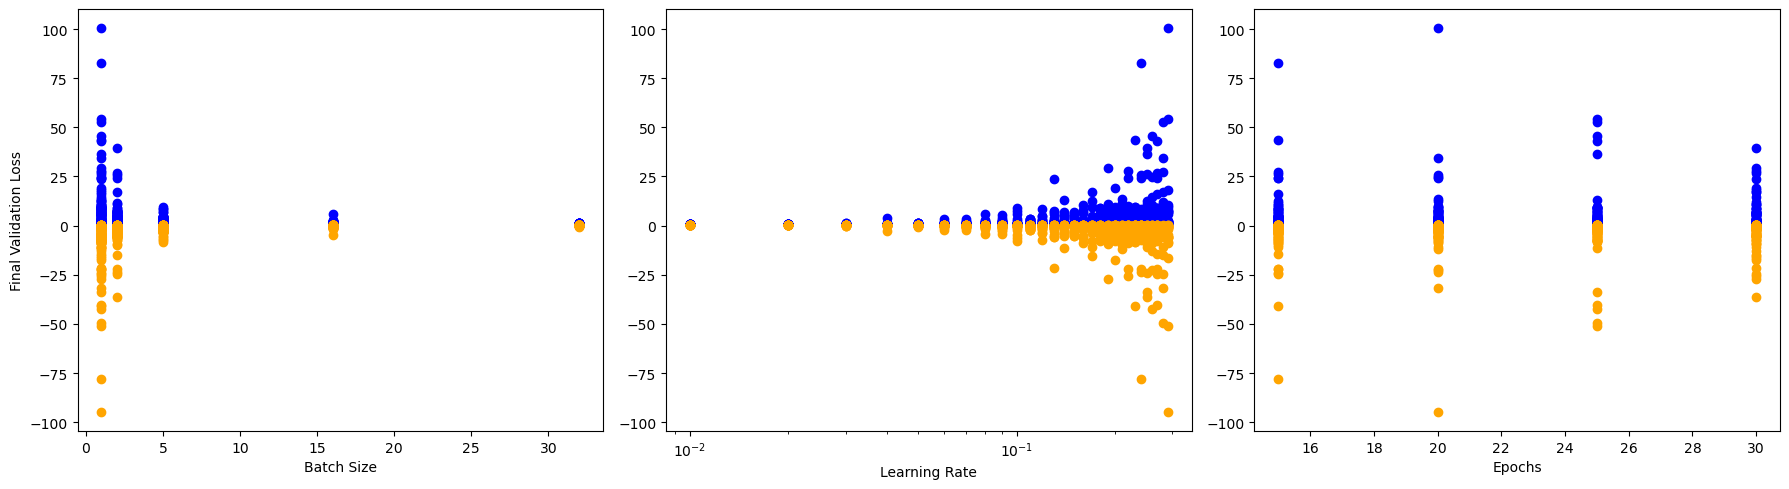

In [598]:
batch_sizes = [exp['batch_size'] for exp in experiment_results]
learning_rates = [exp['learning_rate'] for exp in experiment_results]
epochs_list = [exp['epochs'] for exp in experiment_results]
final_validation_losses = [exp['final_validation_loss'] for exp in experiment_results]
final_r2_scores = [exp['final_r2_score'] for exp in experiment_results]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Final Validation Loss vs. Batch Size
axs[0].scatter(batch_sizes, final_validation_losses, color='blue')
axs[0].scatter(batch_sizes, final_r2_scores, color='orange')
axs[0].set_xlabel('Batch Size')
axs[0].set_ylabel('Final Validation Loss')

# Final Validation Loss vs. Learning Rate
axs[1].scatter(learning_rates, final_validation_losses, color='blue')
axs[1].scatter(learning_rates, final_r2_scores, color='orange')
axs[1].set_xlabel('Learning Rate')
axs[1].set_xscale('log')  # Because learning rates vary exponentially

# Final Validation Loss vs. Epochs
axs[2].scatter(epochs_list, final_validation_losses, color='blue')
axs[2].scatter(epochs_list, final_r2_scores, color='orange')
axs[2].set_xlabel('Epochs')

plt.tight_layout()
plt.show()


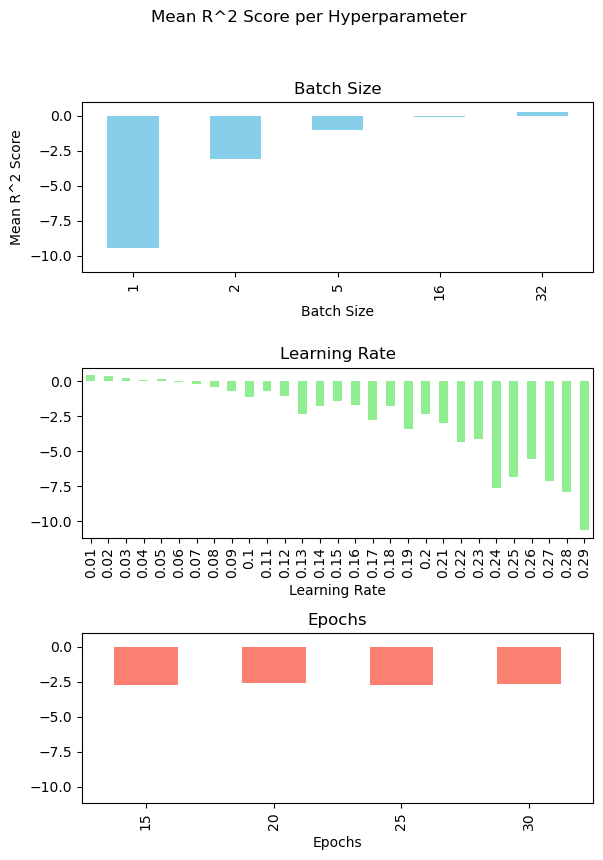

In [645]:
df = pd.DataFrame(experiment_results)

fig, axs = plt.subplots(3, 1, figsize=(6, 9), sharey=True)
fig.suptitle('Mean R^2 Score per Hyperparameter')

# Group by 'batch_size' 
df.groupby('batch_size')['final_r2_score'].mean().plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Batch Size')
axs[0].set_xlabel('Batch Size')
axs[0].set_ylabel('Mean R^2 Score')

# Group by 'learning_rate' 
df.groupby('learning_rate')['final_r2_score'].mean().plot(kind='bar', ax=axs[1], color='lightgreen')
axs[1].set_title('Learning Rate')
axs[1].set_xlabel('Learning Rate')

# Group by 'epochs' 
df.groupby('epochs')['final_r2_score'].mean().plot(kind='bar', ax=axs[2], color='salmon')
axs[2].set_title('Epochs')
axs[2].set_xlabel('Epochs')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [600]:
max_r2_dict = max(experiment_results, key=lambda x: x['final_r2_score'])
print("Dictionary with the maximum R^2 score:", max_r2_dict)

Dictionary with the maximum R^2 score: {'batch_size': 16, 'learning_rate': 0.01, 'epochs': 15, 'final_validation_loss': 0.5678657591342926, 'final_r2_score': 0.4587416637079903}


In [639]:
max_r2_dict

{'batch_size': 16,
 'learning_rate': 0.01,
 'epochs': 15,
 'final_validation_loss': 0.5678657591342926,
 'final_r2_score': 0.4587416637079903}

In [609]:
# Create data loaders
bs = 16
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

# Model with one layer
model = torch.nn.Sequential(
    nn.Linear(X_train.shape[1], 1)           
)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loop(model, train_dl, valid_dl, optimizer, epochs=15)

train loss 0.712 valid loss 0.623 R^2 0.405
train loss 0.584 valid loss 0.566 R^2 0.460
train loss 0.530 valid loss 0.547 R^2 0.479
train loss 0.498 valid loss 0.628 R^2 0.401
train loss 0.476 valid loss 0.555 R^2 0.471
train loss 0.461 valid loss 0.558 R^2 0.468
train loss 0.450 valid loss 0.593 R^2 0.434
train loss 0.443 valid loss 0.564 R^2 0.463
train loss 0.436 valid loss 0.563 R^2 0.463
train loss 0.431 valid loss 0.588 R^2 0.440
train loss 0.428 valid loss 0.728 R^2 0.305
train loss 0.425 valid loss 0.569 R^2 0.457
train loss 0.421 valid loss 0.583 R^2 0.444
train loss 0.418 valid loss 0.577 R^2 0.450
train loss 0.416 valid loss 0.575 R^2 0.452


In [618]:
# Validation predictions

with torch.no_grad(): 
    predictions = []
    for inputs, _ in valid_dl:  
        outputs = model(inputs.float())  
        predictions.append(outputs)

# Concatenate all the predictions
predictions = torch.cat(predictions, dim=0)

# Convert predictions to a NumPy array
predictions_np = predictions.squeeze().numpy()

if len(predictions_np.shape) == 1:
    predictions_np = predictions_np.reshape(-1, 1)

# Unscale
unscaled_predictions = scaler.inverse_transform(predictions_np)
unscaled_predictions = np.round(unscaled_predictions, 2)
pred_val_linreg = pd.Series(unscaled_predictions.flatten())

In [619]:
val_r2_reg = r2_score(y_val, pred_val_linreg)
print("Val R^2 score:", val_r2_reg)

Val R^2 score: 0.4516324595053669


In [620]:
# Test predictions

with torch.no_grad():  
    predictions = []
    for inputs, _ in test_dl:  
        outputs = model(inputs.float()) 
        predictions.append(outputs) 

# Concatenate all the predictions
predictions = torch.cat(predictions, dim=0)

# Convert predictions to a NumPy array
predictions_np = predictions.squeeze().numpy()

if len(predictions_np.shape) == 1:
    predictions_np = predictions_np.reshape(-1, 1)

# Unscale
unscaled_predictions = scaler.inverse_transform(predictions_np)
unscaled_predictions = np.round(unscaled_predictions, 2)
pred_test_linreg = pd.Series(unscaled_predictions.flatten())

### Boosted Trees

In [531]:
def plot_parameter_impact(ax, parameter_name, parameter_values, X_train, X_val, y_train, y_val):
    r2s_train = []
    r2s_val = []

    for value in parameter_values:
        params = {parameter_name: value, 'objective': 'reg:squarederror', 'enable_categorical': True}
        model = xgb.XGBRegressor(**params)

        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Evaluate the model
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        r2s_train.append(train_r2)
        r2s_val.append(val_r2)

    # Plotting on the provided axis
    ax.plot(parameter_values, r2s_train, label="Train R^2")
    ax.plot(parameter_values, r2s_val, label="Validation R^2")
    ax.set_title(f'{parameter_name}')
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('R^2 Score')
    ax.legend()

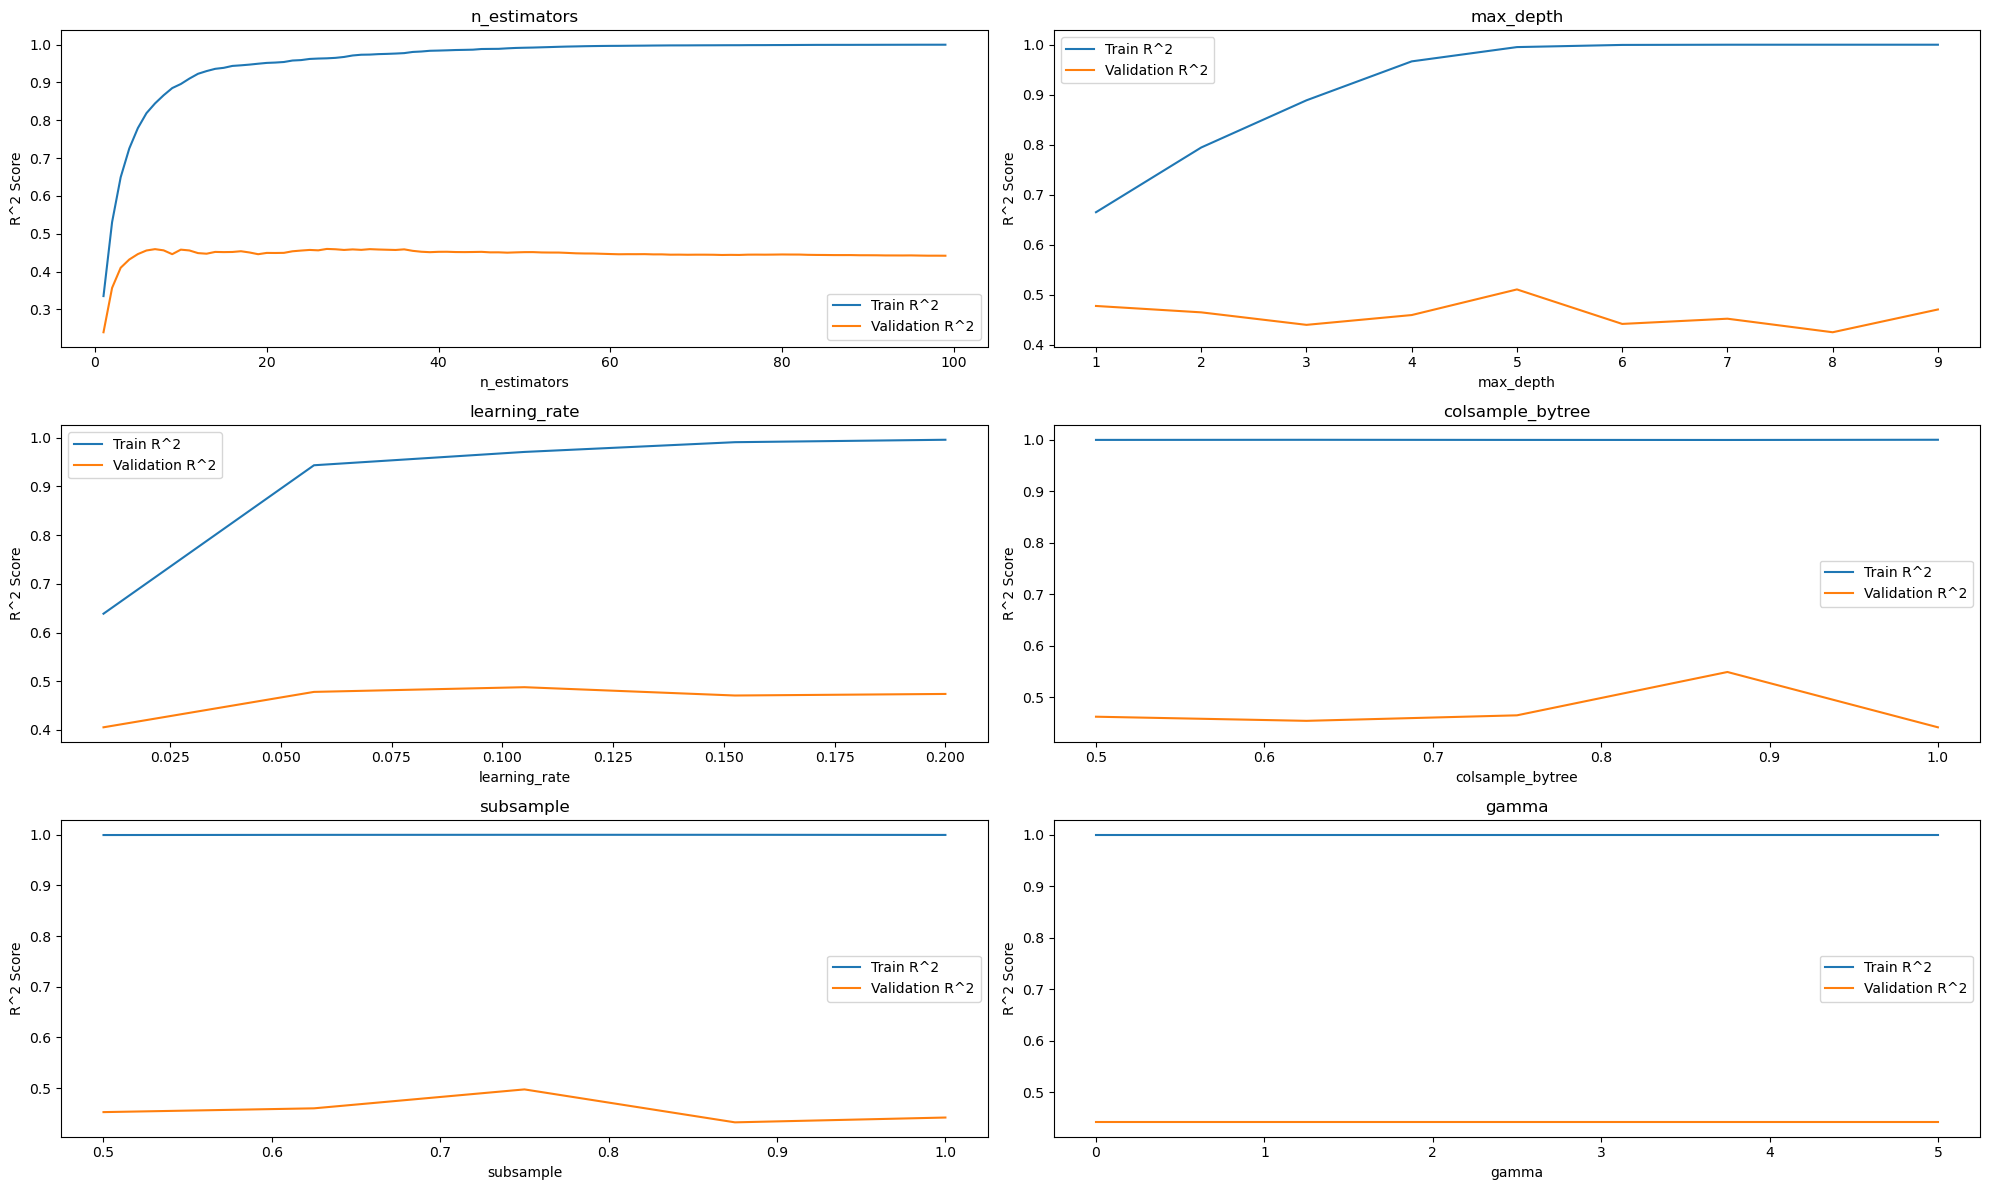

In [535]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4)

# Define parameter ranges
parameters = {
    'n_estimators': range(1, 100, 1),
    'max_depth': range(1, 10, 1),
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'gamma': np.linspace(0, 5, 5)
}

for ax, (param, values) in zip(axs.flatten(), parameters.items()):
    plot_parameter_impact(ax, param, values, X_train, X_val, y_train, y_val)

plt.tight_layout()
plt.show()

In [536]:
# Initialize the XGBRegressor
xgb_reg = xgb.XGBRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [15, 30, 50, 100],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': np.arange(0.05, .14, 0.02),
    'colsample_bytree': [0.5, 0.85, 0.9],
    'subsample': np.linspace(0.6, 0.9, 5)
}

In [537]:
# Initialize GridSearchCV with R^2 scoring
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.85, 0.9],
                         'learning_rate': array([0.05, 0.07, 0.09, 0.11, 0.13]),
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [15, 30, 50, 100],
                         'subsample': array([0.6  , 0.675, 0.75 , 0.825, 0.9  ])},
             scoring='r2', verbose=1)

In [538]:
# Best parameters found
print("Best parameters:", grid_search.best_params_)
# Best score achieved
print("Best score:", grid_search.best_score_)
# Best estimator
best_model = grid_search.best_estimator_

Best parameters: {'colsample_bytree': 0.85, 'learning_rate': 0.09000000000000001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
Best score: 0.6340182562665229


In [539]:
# Use the best model for predictions
best_model = grid_search.best_estimator_
y_hat = best_model.predict(X_val)
val_r2_boosted = r2_score(y_val, y_hat)
print("Val R^2 score:", val_r2_boosted)

Val R^2 score: 0.5097909718007996


In [540]:
# Get Val and Test predictions
pred_val_boosted = best_model.predict(X_val)
pred_test_boosted = best_model.predict(X_test)

## Random Forest

In [543]:
def plot_parameter_impact(ax, parameter_name, parameter_values, X_train, X_val, y_train, y_val):
    r2s_train = []
    r2s_val = []

    for value in parameter_values:
        params = {parameter_name: value}
        model = RandomForestRegressor(**params)

        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Evaluate the model
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        r2s_train.append(train_r2)
        r2s_val.append(val_r2)

    # Plotting on the provided axis
    ax.plot(parameter_values, r2s_train, label="Train R^2")
    ax.plot(parameter_values, r2s_val, label="Validation R^2")
    ax.set_title(f'{parameter_name}')
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('R^2 Score')
    ax.legend()

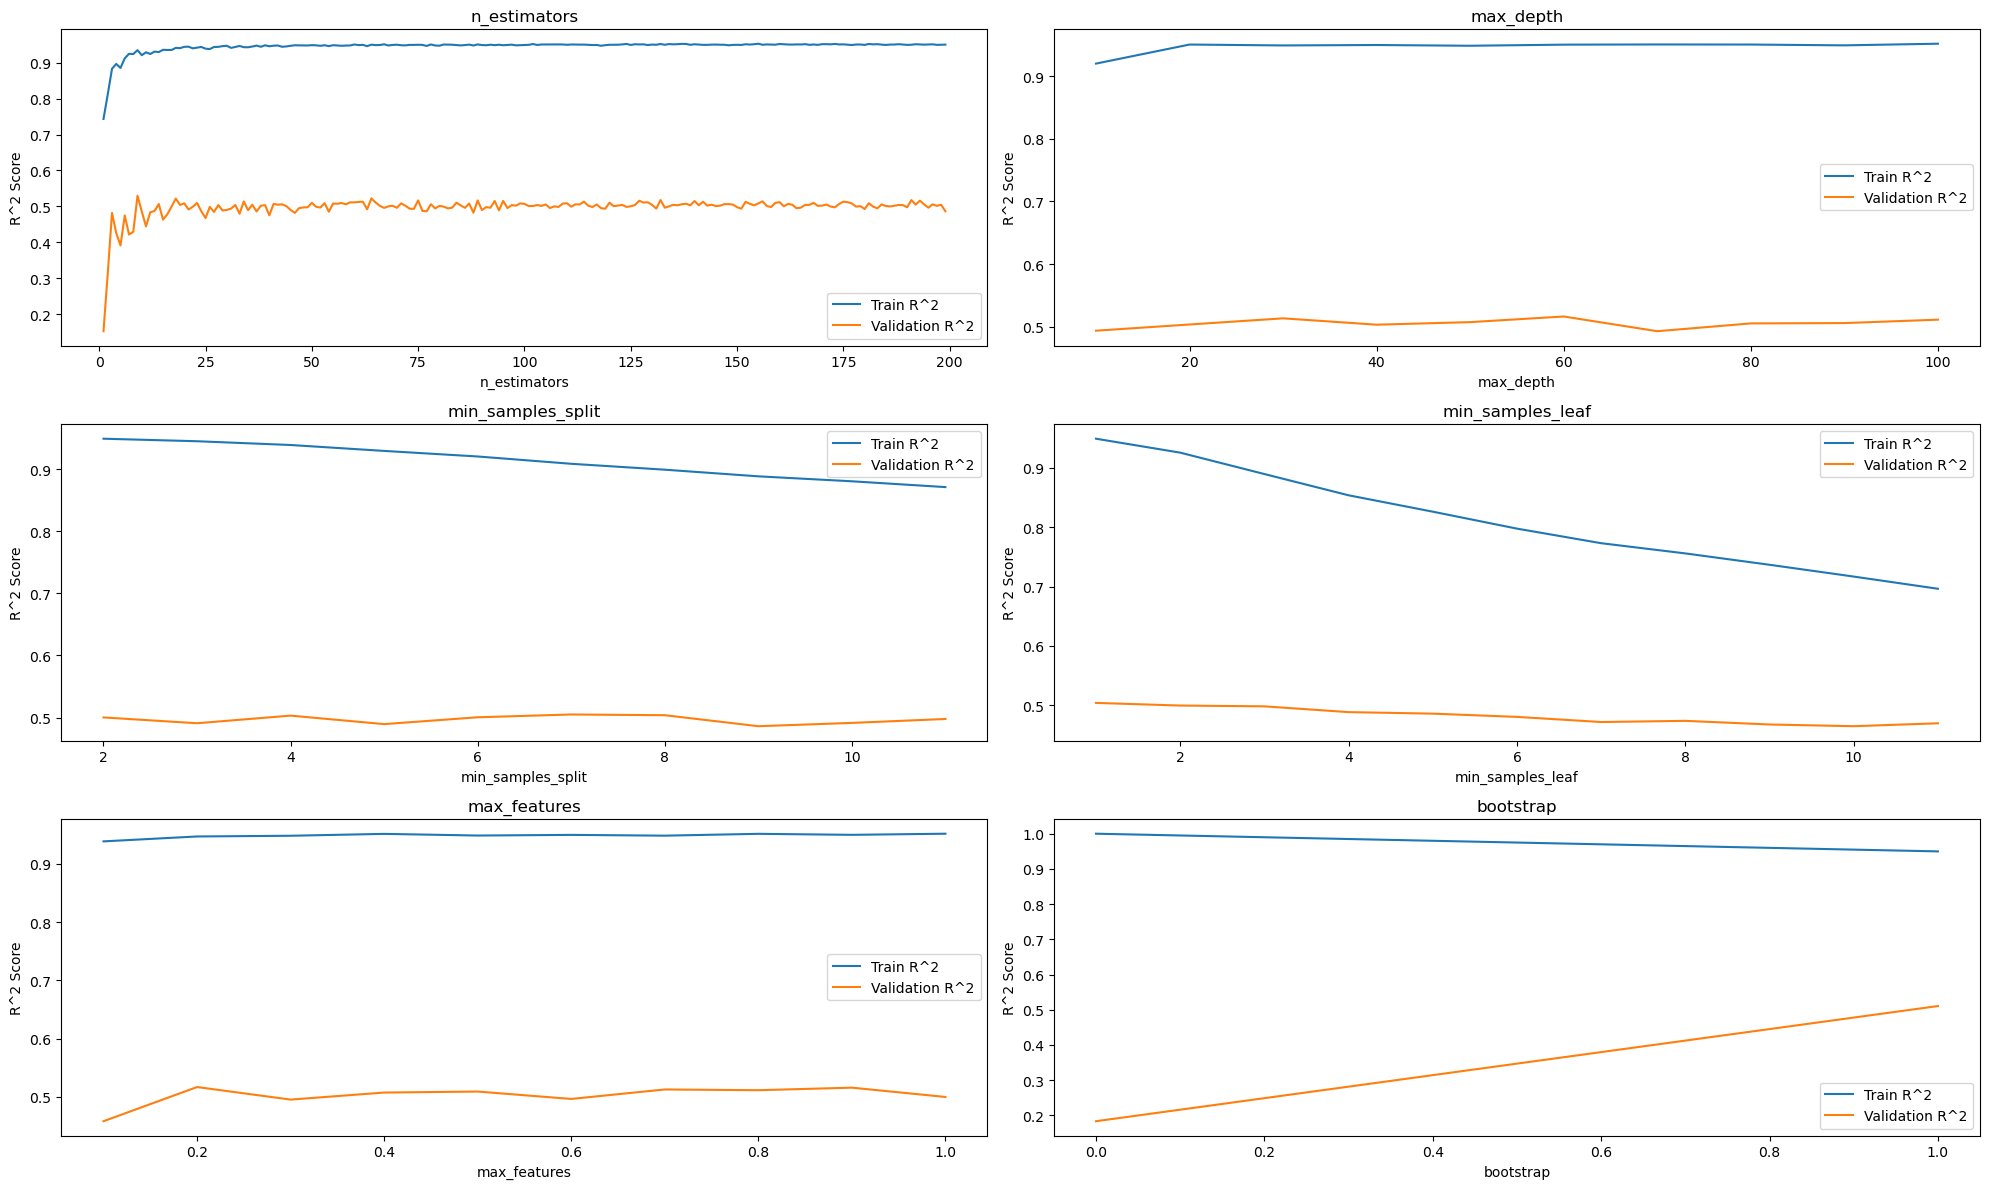

In [551]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4)

# Define parameter ranges
parameters = {
    'n_estimators': range(1, 200, 1),
    'max_depth': range(10, 110, 10),
    'min_samples_split': np.arange(2, 12, 1),
    'min_samples_leaf': np.arange(1, 12, 1),
    'max_features': np.arange(0.1, 1.1, 0.1),
    'bootstrap': [True, False]
}
for ax, (param, values) in zip(axs.flatten(), parameters.items()):
    plot_parameter_impact(ax, param, values, X_train, X_val, y_train, y_val)

plt.tight_layout()
plt.show()

In [552]:
# Initialize the RandomForestRegressor
rf_reg = RandomForestRegressor()

# Define the parameter grid to search
param_grid = {
    'n_estimators': range(25, 150, 25),
    'max_depth': [None, 30, 45, 60],
    'min_samples_split': np.arange(2, 12, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': np.arange(0.2, 0.6, 0.1),
    'bootstrap': [False]
}

In [553]:
# Initialize GridSearchCV with R^2 scoring
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [None, 30, 45, 60],
                         'max_features': array([0.2, 0.3, 0.4, 0.5]),
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'n_estimators': range(25, 150, 25)},
             scoring='r2', verbose=1)

In [554]:
# Best parameters found
print("Best parameters:", grid_search.best_params_)
# Best score achieved (R^2)
print("Best score (R^2):", grid_search.best_score_)


Best parameters: {'bootstrap': False, 'max_depth': 45, 'max_features': 0.4000000000000001, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 125}
Best score (R^2): 0.6316105954257409


In [555]:
# Best estimator
best_model = grid_search.best_estimator_
# Predictions with the best model
y_hat = best_model.predict(X_val)

# Computing R^2 score for the test set
val_r2_rf = r2_score(y_val, y_hat)
print("Val R^2 score:", val_r2_rf)

Val R^2 score: 0.5244301386643008


In [556]:
# Get Val and Test predictions
pred_val_rf = best_model.predict(X_val)
pred_test_rf = best_model.predict(X_test)

## Cat Boosted

In [559]:
def plot_parameter_impact(ax, parameter_name, parameter_values, X_train, X_val, y_train, y_val):
    r2s_train = []
    r2s_val = []

    for value in parameter_values:
        params = {parameter_name: value, 'silent': True}
        model = CatBoostRegressor(**params)

        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Evaluate the model
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        r2s_train.append(train_r2)
        r2s_val.append(val_r2)

    # Plotting on the provided axis
    ax.plot(parameter_values, r2s_train, label="Train R^2")
    ax.plot(parameter_values, r2s_val, label="Validation R^2")
    ax.set_title(f'{parameter_name}')
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('R^2 Score')
    ax.legend()

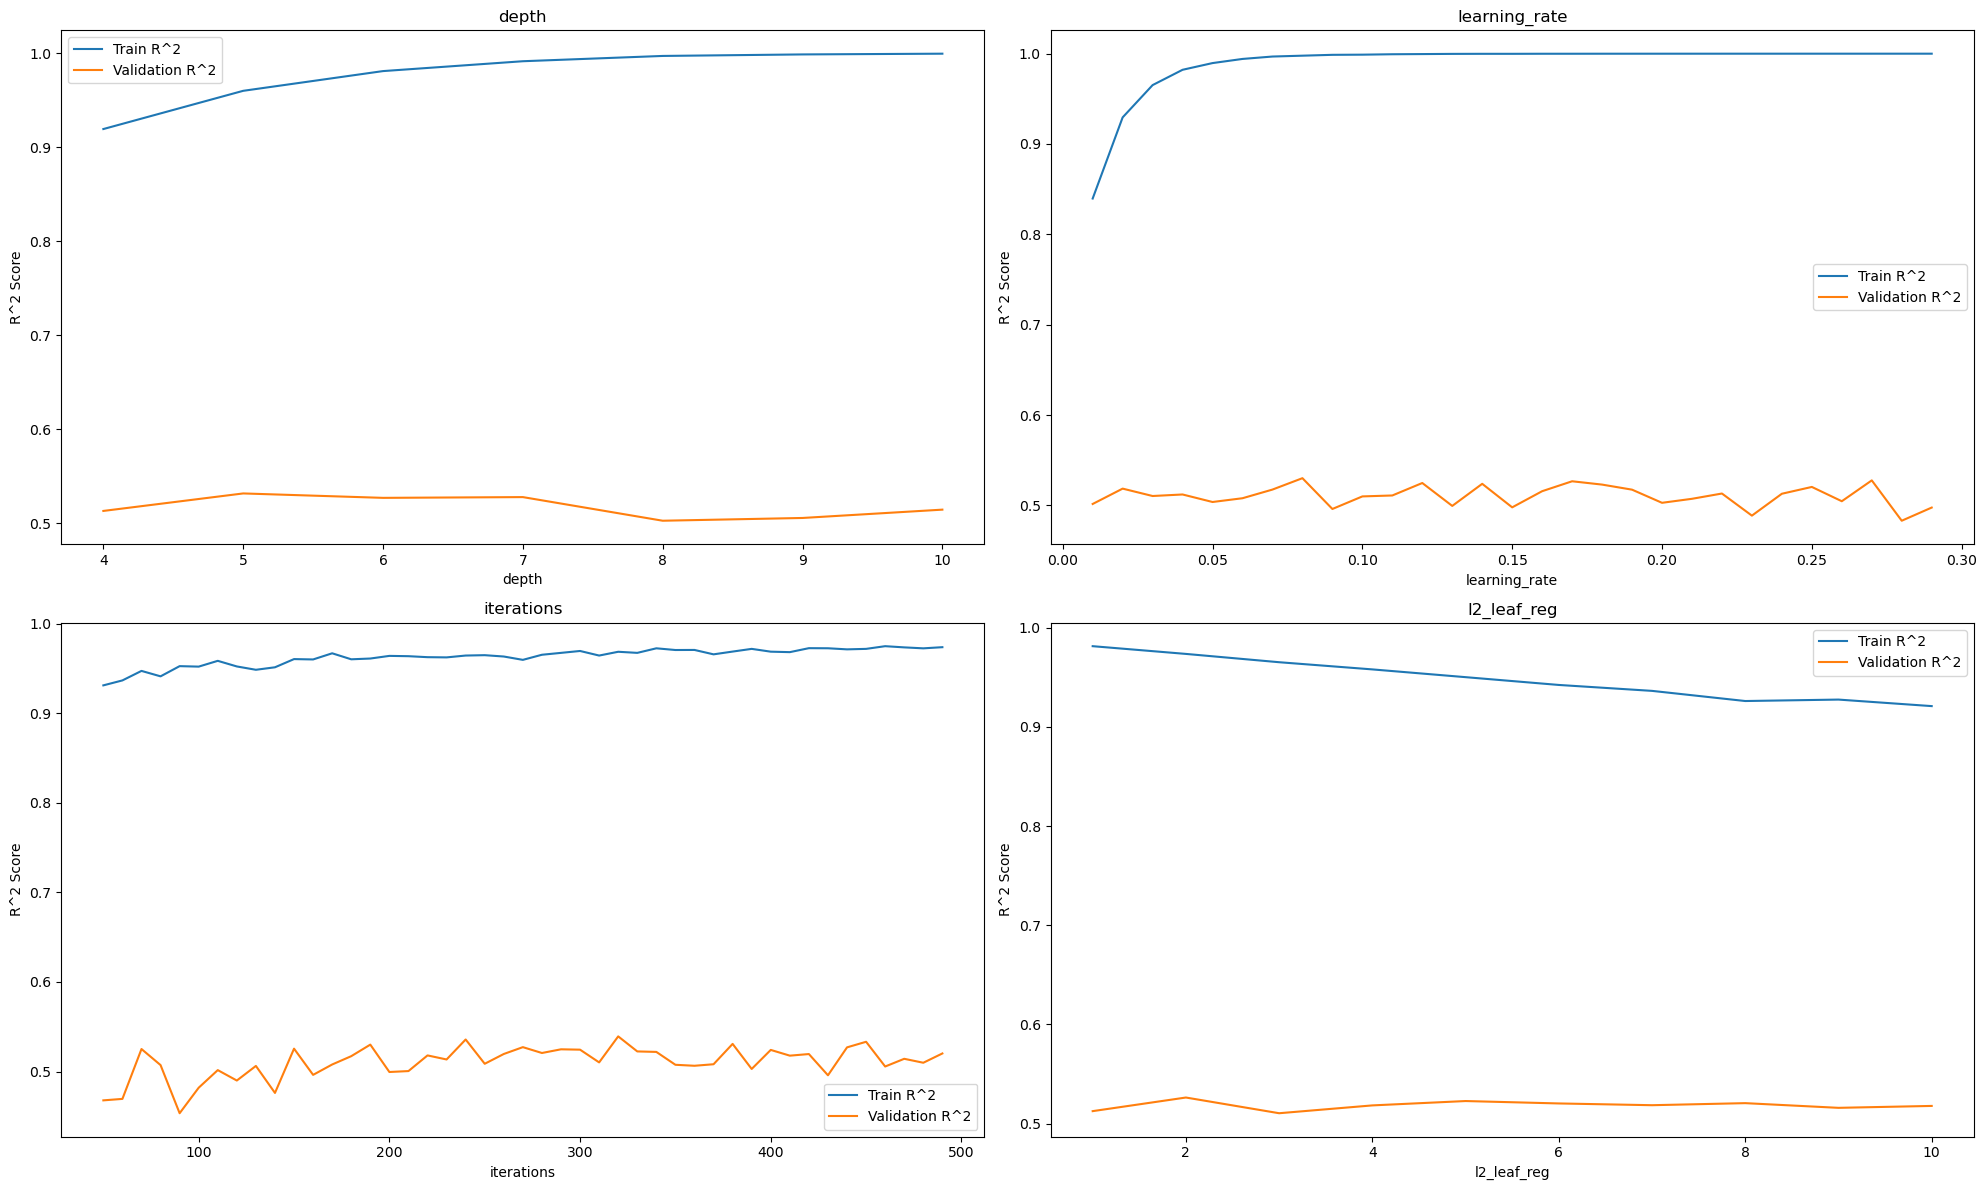

In [560]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4)

# Define parameter ranges
parameters = {
    'depth': np.arange(4, 11, 1),
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'iterations': np.arange(50, 500, 10),
    'l2_leaf_reg': np.arange(1,11, 1)
}

for ax, (param, values) in zip(axs.flatten(), parameters.items()):
    plot_parameter_impact(ax, param, values, X_train, X_val, y_train, y_val)

plt.tight_layout()
plt.show()

In [602]:
# Initialize the CatBoostRegressor
cb_reg = CatBoostRegressor(silent=True)  # `silent=True` to avoid non-stop logging of training progress

# Define the parameter grid to search
param_grid = {
    'depth': np.arange(4, 8, 1),
    'learning_rate': np.arange(0.01, 0.3, 0.02),
    'iterations': [50, 150, 300, 500],
    'l2_leaf_reg': [2, 5, 8]
}

In [603]:
# Initialize GridSearchCV with R^2 scoring
grid_search = GridSearchCV(estimator=cb_reg, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x2a9a70e50>,
             n_jobs=-1,
             param_grid={'depth': array([4, 5, 6, 7]),
                         'iterations': [50, 150, 300, 500],
                         'l2_leaf_reg': [2, 5, 8],
                         'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29])},
             scoring='r2', verbose=1)

In [604]:
# Best parameters found
print("Best parameters:", grid_search.best_params_)
# Best score achieved (R^2)
print("Best score (R^2):", grid_search.best_score_)
# Best estimator for predictions
best_model = grid_search.best_estimator_

# Predictions with the best model
y_hat = best_model.predict(X_val)
# Computing R^2 score for the test set
val_r2_boosted = r2_score(y_val, y_hat)
print("Val R^2 score:", val_r2_boosted)


Best parameters: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 8, 'learning_rate': 0.049999999999999996}
Best score (R^2): 0.6237687332673966
Val R^2 score: 0.5222050324589229


In [605]:
# Get Val and Test predictions
pred_val_cat = best_model.predict(X_val)
pred_test_cat = best_model.predict(X_test)

## Ensemble

In [634]:
pred_val = np.mean([pred_val_linreg, pred_val_boosted, pred_val_rf, pred_val_cat], axis=0) 
val_r2 = r2_score(y_val, pred_val)
val_r2

0.5328233255962527

In [638]:
from itertools import combinations

models = [
    ('Linear Regression', pred_val_linreg),
    ('Boosted Trees', pred_val_boosted),
    ('Random Forest', pred_val_rf),
    ('CatBoost', pred_val_cat)
]
results = []
# Generate all combinations of the models
for r in range(2, len(models) + 1):
    for combo in combinations(models, r):
        # Extract the model names and predictions
        combo_names, combo_preds = zip(*combo)
        
        # Calculate the mean prediction and r^2 for the current combination
        pred_mean = np.mean(combo_preds, axis=0)
        val_r2 = r2_score(y_val, pred_mean)
        results.append({'Models': ' + '.join(combo_names), 'Val R^2': val_r2})

results_df = pd.DataFrame(results)
results_df.sort_values(by='Val R^2', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

,Models,Val R^2
0,Random Forest + CatBoost,0.532823
1,Boosted Trees + Random Forest + CatBoost,0.531479
2,Linear Regression + Boosted Trees + Random For...,0.529334
3,Linear Regression + Random Forest + CatBoost,0.529085
4,Boosted Trees + Random Forest,0.528748
5,Linear Regression + Boosted Trees + Random Forest,0.526199
6,Boosted Trees + CatBoost,0.523364
7,Linear Regression + Random Forest,0.522421
8,Linear Regression + Boosted Trees + CatBoost,0.518429
9,Linear Regression + CatBoost,0.509765


In [643]:
# df stylized for presentation
styled_df = results_df.style.set_properties(subset=['Models'], **{'text-align': 'left'}) \
                            .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]).hide(axis="index")
styled_df


Models,Val R^2
Random Forest + CatBoost,0.532823
Boosted Trees + Random Forest + CatBoost,0.531479
Linear Regression + Boosted Trees + Random Forest + CatBoost,0.529334
Linear Regression + Random Forest + CatBoost,0.529085
Boosted Trees + Random Forest,0.528748
Linear Regression + Boosted Trees + Random Forest,0.526199
Boosted Trees + CatBoost,0.523364
Linear Regression + Random Forest,0.522421
Linear Regression + Boosted Trees + CatBoost,0.518429
Linear Regression + CatBoost,0.509765


In [636]:
# Ensemble predictions
predictions = np.mean([pred_test_rf, pred_test_cat], axis=0) #pred_test_boosted
df_solutions = pd.DataFrame({'id':X_test.index, 'price': predictions})
df_solutions

,id,price
0,0,339318.008223
1,1,341406.415549
2,2,297844.905638
3,3,368229.600348
4,4,313211.829050
...,...,...
127,127,378077.805576
128,128,299490.001254
129,129,331879.116868
130,130,354113.837810


In [637]:
df_solutions.to_csv('solutions.csv', index=False)